# Heesoo Kim ECE 570 Reimplementation
IMMA model requires at least 20GB just for its regular model. 
Due to this reason, I lowered the resolution from 512 to 256, epoch from 50 to 11, and image size from float32 to float16. Moreover, I experimented with different GPUs to run my reimplementation code. 

### GPUs that can run my code
- A10 GPU 1 node 10 cores
- A30 GPU 1 node 8 cores
- A100 GPU 1 node 16 cores

### GPUs that returned Out Of Memory (OOM) while running
- V100 GPU 1 node 8 cores
- V100 GPU 1 node 16 cores
- (Google Colab Free Version) T4 GPU

In [1]:
# Install required dependencies
!pip install -r './requirements.txt'

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-96tj1oy7
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-96tj1oy7
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1


In [2]:
# Import necessary libraries
import os
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.checkpoint import checkpoint
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoTokenizer
import diffusers
from diffusers import StableDiffusionPipeline, AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel
from diffusers.models.attention_processor import LoRAAttnProcessor
from diffusers.loaders import AttnProcsLayers
from diffusers.optimization import get_scheduler
from tqdm import tqdm
from accelerate import Accelerator
import matplotlib.pyplot as plt
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
import pandas as pd
import numpy as np
import clip
import pathlib
import lpips

In [3]:
# print("Current working directory:", os.getcwd())

In [4]:
# Clear the cache
torch.cuda.empty_cache()

# Split the memory blocks into smaller pieces for Google Colab
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "garbage_collection_threshold:0.6,max_split_size_mb:128"

### Parameter Initialization 

In [5]:
class OptimizerConfig:
    beta1 = 0.9
    beta2 = 0.999
    weight_decay = 1e-2
    epsilon = 1e-08
    learning_rate_lora = 1e-4

class TrainingConfig:
    num_epochs = 11 # changed from 50 to 10 for lighter model
    inner_loop_steps = 5
    outer_loop_steps = 5
    gradient_accumulation_steps = 4
    max_steps = 121
    max_grad_norm = 1.0

class DataConfig:
    resolution = 256 # changed from 512 to 256 for lighter model
    center_crop = False
    random_flip = True
    reference_path = "./reference"
    imma_path = "./imma"
    base_path = "./base"
    data_type = torch.float16

class Config:
    # training = TrainingConfig()
    # optimizer = OptimizerConfig()
    # data = DataConfig()
    validation_prompt = "An artwork by Van Gogh"
    num_validation_images = 4
    seed = 42
    pretrained_model = "CompVis/stable-diffusion-v1-4"
    device = "cuda"
    validation_steps = 11

config = Config()

In [6]:
# Load scheduler, tokenizer and models.
# Denoising Diffusion Probabilistic Models = DDPM
# Contrastive Language-Image Pre-Training: NN trained on iamge, text paris
noise_scheduler = DDPMScheduler.from_pretrained(config.pretrained_model, subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained(config.pretrained_model, subfolder="tokenizer", revision=None)
text_encoder = CLIPTextModel.from_pretrained(config.pretrained_model, subfolder="text_encoder", revision=None)
vae = AutoencoderKL.from_pretrained(config.pretrained_model, subfolder="vae", revision=None)
unet = UNet2DConditionModel.from_pretrained(config.pretrained_model, subfolder="unet", revision=None)

In [7]:
# Save memory by freezing parameters
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

### Data Preprocessing 

In [8]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, metadata_file, tokenizer, resolution):
        self.data_dir = data_dir
        self.metadata = pd.read_csv(metadata_file)
        self.tokenizer = tokenizer
        self.resolution = resolution

        # Set image and caption columns
        self.image_column = "file_name"
        self.caption_column = "prompt"

        # Define transforms
        self.transforms = transforms.Compose([
            transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(resolution) if DataConfig.center_crop else transforms.RandomCrop(resolution),
            transforms.RandomHorizontalFlip() if DataConfig.random_flip else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        # Get image and prompt
        image_file = self.metadata.iloc[idx][self.image_column]
        prompt = self.metadata.iloc[idx][self.caption_column]

        # Load and preprocess image
        image_path = os.path.join(self.data_dir, image_file)
        image = Image.open(image_path).convert("RGB")
        pixel_values = self.transforms(image)

        # Tokenize caption
        tokenized_prompt = self.tokenizer(
            prompt, max_length=77, padding="max_length", truncation=True, return_tensors="pt"
        ).input_ids

        return {
            "pixel_values": pixel_values,
            "input_ids": tokenized_prompt.squeeze(0),
        }

In [9]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples]).to(DataConfig.data_type)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([example["input_ids"] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids}

In [10]:
def configure_lora_processors(unet_model):
    """
    Configures LoRA attention processors for a given UNet model.
    """
    attention_processors = {}
    block_channels = unet_model.config.block_out_channels
    reversed_channels = list(reversed(block_channels))

    for processor_name in unet_model.attn_processors.keys():
        if processor_name.endswith("attn1.processor"):
            cross_attention_dim = None
        else:
            cross_attention_dim = unet_model.config.cross_attention_dim

        # Determine hidden size based on the processor's block location
        if "mid_block" in processor_name:
            hidden_size = block_channels[-1]
        elif "up_blocks" in processor_name:
            block_idx = int(processor_name.split(".")[1])
            hidden_size = reversed_channels[block_idx]
        elif "down_blocks" in processor_name:
            block_idx = int(processor_name.split(".")[1])
            hidden_size = block_channels[block_idx]
        else:
            raise ValueError(f"Unknown processor block in name: {processor_name}")

        # Assign a LoRA attention processor
        attention_processors[processor_name] = LoRAAttnProcessor(
            hidden_size=hidden_size,
            cross_attention_dim=cross_attention_dim,
            rank=4,  # Default rank
        )

    return attention_processors


### Lora Initialization

In [11]:
# Load the UNet model from the Stable Diffusion pipeline
unet = UNet2DConditionModel.from_pretrained(config.pretrained_model, subfolder="unet").to("cuda")

# Generate and set LoRA layers for the UNet
lora_processors = configure_lora_processors(unet)

# Apply LoRA processors to the model's attention layers
for name, module in unet.attn_processors.items():
    if name in lora_processors:
        unet.attn_processors[name] = lora_processors[name]
        
# Ensure LoRA processors are applied uniformly across the model
unet.set_attn_processor(configure_lora_processors(unet))

# Consolidate all LoRA layers for future state tracking or modifications
lora_layers = AttnProcsLayers(unet.attn_processors)
initial_state_dict = lora_layers.state_dict()

In [12]:
def freeze_grad(params):
    for module in params.values():  # Iterate over the modules, not the keys
        if hasattr(module, 'parameters'):  # Ensure the object has parameters
            for param in module.parameters():  # Access each parameter
                param.requires_grad = False

def free_grad(params):
    for module in params.values():  # Iterate over the modules, not the keys
        if hasattr(module, 'parameters'):  # Ensure the object has parameters
            for param in module.parameters():  # Access each parameter
                param.requires_grad = True

In [13]:
def training_wo_imma(
    unet, vae, text_encoder, tokenizer, dataloader, optimizer, lr_scheduler, 
    optimizer_lora, lr_scheduler_lora, accelerator
):
    global_step = 0
    for epoch in range(TrainingConfig.num_epochs):
        unet.train()
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{TrainingConfig.num_epochs}")
        train_loss = 0.0

        for step, batch in enumerate(progress_bar):
            with accelerator.accumulate(unet):
                # Move input data to the correct device
                pixel_values = batch["pixel_values"].to(config.device, non_blocking=True).to(dtype=vae.dtype)
                input_ids = batch["input_ids"].to(config.device, non_blocking=True)

                # Encode images to latent space
                latents = vae.encode(pixel_values).latent_dist.sample()
                latents *= vae.config.scaling_factor
                latents = latents.to(dtype=unet.dtype)

                # Add noise
                noise = torch.randn_like(latents)
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.size(0),), device=latents.device)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
                noisy_latents = noisy_latents.to(dtype=unet.dtype)

                # Get text embeddings
                encoder_hidden_states = text_encoder(input_ids)[0]

                # Predict noise
                model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # Compute loss
                target = noise if noise_scheduler.config.prediction_type == "epsilon" else \
                         noise_scheduler.get_velocity(latents, noise, timesteps)
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), TrainingConfig.max_grad_norm)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

                train_loss += loss.item() / TrainingConfig.gradient_accumulation_steps
                global_step += 1

                progress_bar.set_postfix({"loss": train_loss})
                train_loss = 0.0

                # Validation
                if global_step % config.validation_steps == 0:
                    generate_base_image(unet, vae, text_encoder, tokenizer, epoch)

                if global_step >= TrainingConfig.max_steps:
                    break

        print(f"Epoch {epoch+1} completed!")


In [14]:
def generate_base_image(unet, vae, text_encoder, tokenizer, step):
    unet.eval()
    pipeline = DiffusionPipeline.from_pretrained(
    config.pretrained_model,
    unet=unet,
    vae=vae,
    tokenizer=tokenizer,
    torch_dtype=DataConfig.data_type,
    ).to(config.device)

    save_path = "./base"
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok=True)
    generator = torch.Generator(device=config.device).manual_seed(config.seed)
    fig, axes = plt.subplots(2, 2, figsize=(5, 5))
    
    images = []
    for i in range(config.num_validation_images):
        output = pipeline(config.validation_prompt, num_inference_steps=30, generator=generator)
        image = output.images[0]
        
        image_save_path = os.path.join(save_path, f"{step}_{i}.png")
        image.save(image_save_path)

        np_image = np.asarray(image)
        row, col = divmod(i, 2)  # Determine row and column in the 2x2 grid
        axes[row, col].imshow(np_image)
        axes[row, col].axis('off')  # Remove axes for better visualization
        axes[row, col].set_title(f"Base Image {i+1}")
  
    plt.tight_layout()
    plt.show()
    plt.close(fig)  # Close the figure to free memory

In [15]:
def validate_model(unet, vae, text_encoder, tokenizer, step):
    unet.eval()
    pipeline = DiffusionPipeline.from_pretrained(
    config.pretrained_model,
    unet=unet,
    vae=vae,
    tokenizer=tokenizer,
    torch_dtype=DataConfig.data_type,
    ).to(config.device)

    save_path = "./imma"
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok=True)
    generator = torch.Generator(device=config.device).manual_seed(config.seed)
    fig, axes = plt.subplots(2, 2, figsize=(5, 5))
    
    images = []
    for i in range(config.num_validation_images):
        output = pipeline(config.validation_prompt, num_inference_steps=30, generator=generator)
        image = output.images[0]
        
        image_save_path = os.path.join(save_path, f"{step}_{i}.png")
        image.save(image_save_path)

        np_image = np.asarray(image)
        row, col = divmod(i, 2)  # Determine row and column in the 2x2 grid
        axes[row, col].imshow(np_image)
        axes[row, col].axis('off')  # Remove axes for better visualization
        axes[row, col].set_title(f"Validation Image {i+1}")
  
    plt.tight_layout()
    plt.show()
    plt.close(fig)  # Close the figure to free memory

### Perform high level and low level tasks as mentioned in the paper

In [16]:
def training_w_imma(
    unet, vae, text_encoder, tokenizer, dataloader, optimizer, lr_scheduler, 
    optimizer_lora, lr_scheduler_lora, accelerator
):
    global_step = 0
    for epoch in range(TrainingConfig.num_epochs):
        unet.train()
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{TrainingConfig.num_epochs}")
        train_loss = 0.0

        for step, batch in enumerate(progress_bar):
            with accelerator.accumulate(unet):
                # Move input data to the correct device
                pixel_values = batch["pixel_values"].to(config.device, non_blocking=True).to(dtype=vae.dtype)
                input_ids = batch["input_ids"].to(config.device, non_blocking=True)

                # Encode images to latent space
                latents = vae.encode(pixel_values).latent_dist.sample()
                latents *= vae.config.scaling_factor
                latents = latents.to(dtype=unet.dtype)

                # Add noise
                noise = torch.randn_like(latents)
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.size(0),), device=latents.device)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
                noisy_latents = noisy_latents.to(dtype=unet.dtype)

                # Get text embeddings
                encoder_hidden_states = text_encoder(input_ids)[0]

                # Predict noise
                model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # Compute loss
                target = noise if noise_scheduler.config.prediction_type == "epsilon" else \
                         noise_scheduler.get_velocity(latents, noise, timesteps)
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

                # Bi-level optimization
                if step % (TrainingConfig.inner_loop_steps + TrainingConfig.outer_loop_steps) < TrainingConfig.inner_loop_steps:
                    # Inner loop: Optimize LoRA parameters
                    accelerator.backward(loss)
                    if accelerator.sync_gradients:
                        params_to_clip = lora_layers.parameters()
                        accelerator.clip_grad_norm_(params_to_clip, TrainingConfig.max_grad_norm)
                    optimizer_lora.step()
                    lr_scheduler_lora.step()
                    optimizer_lora.zero_grad()
                else:
                    # Outer loop: Optimize other model parameters
                    accelerator.backward(-loss)  # Maximize loss
                    if accelerator.sync_gradients:
                        accelerator.clip_grad_norm_(unet.parameters(), TrainingConfig.max_grad_norm)
                    optimizer.step()
                    lr_scheduler.step()
                    optimizer.zero_grad()

                train_loss += loss.item() / TrainingConfig.gradient_accumulation_steps
                global_step += 1

                progress_bar.set_postfix({"loss": train_loss})
                train_loss = 0.0

                # Validation
                if global_step % config.validation_steps == 0:
                    validate_model(unet, vae, text_encoder, tokenizer, epoch)

                if global_step >= TrainingConfig.max_steps:
                    break

        print(f"Epoch {epoch+1} completed!")


### Model Initialization

In [17]:
from accelerate import Accelerator

# Initialize Accelerator
# reduced the memory by using FP16 tensor instead of FP32
accelerator = Accelerator(mixed_precision="fp16")
torch.set_default_dtype(DataConfig.data_type)

# Initialize DataLoader
data_dir = DataConfig.reference_path
metadata_file = os.path.join(data_dir, "metadata.csv")
dataset = CustomDataset(data_dir, metadata_file, tokenizer, resolution=DataConfig.resolution)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

# Ensure all models are moved to the same device
vae.to(config.device)
unet.to(config.device)
text_encoder.to(config.device)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [18]:
# Initialize optimizer and scheduler
optimizer = torch.optim.AdamW(unet.parameters(), lr=5e-6)
lr_scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer)

optimizer_lora = torch.optim.AdamW(
        lora_layers.parameters(),
        lr=OptimizerConfig.learning_rate_lora,
        betas=(OptimizerConfig.beta1, OptimizerConfig.beta2),
        weight_decay=OptimizerConfig.weight_decay,
        eps=OptimizerConfig.epsilon,
    )

lr_scheduler_lora = get_scheduler(
        "constant",
        optimizer=optimizer_lora,
        num_warmup_steps=500 * TrainingConfig.gradient_accumulation_steps,
        num_training_steps=500 * TrainingConfig.gradient_accumulation_steps,
    )

unet, vae, text_encoder, optimizer, optimizer_lora, lr_scheduler_lora, lr_scheduler, dataloader = accelerator.prepare(
    unet, vae, text_encoder, optimizer, optimizer_lora, lr_scheduler_lora, lr_scheduler, dataloader
)

### Training without IMMA

Epoch 1/11:  91%|█████████ | 10/11 [00:05<00:00,  2.37it/s, loss=0.0224] 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

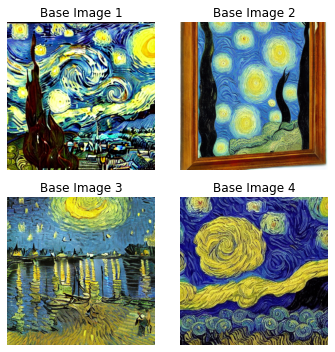

Epoch 1/11: 100%|██████████| 11/11 [00:27<00:00,  2.50s/it, loss=0.0224]


Epoch 1 completed!


Epoch 2/11:  91%|█████████ | 10/11 [00:04<00:00,  2.45it/s, loss=0.00297]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

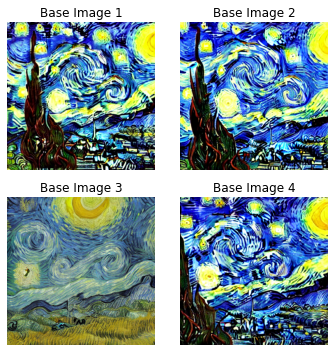

Epoch 2/11: 100%|██████████| 11/11 [00:26<00:00,  2.42s/it, loss=0.00297]


Epoch 2 completed!


Epoch 3/11:  91%|█████████ | 10/11 [00:04<00:00,  2.44it/s, loss=0.00229]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

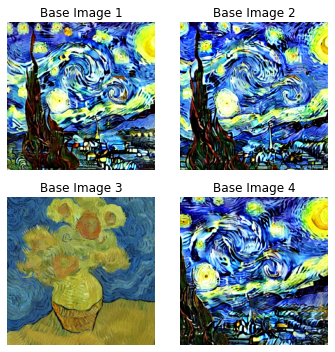

Epoch 3/11: 100%|██████████| 11/11 [00:26<00:00,  2.44s/it, loss=0.00229]


Epoch 3 completed!


Epoch 4/11:  91%|█████████ | 10/11 [00:04<00:00,  2.36it/s, loss=0.000822]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/30 [00:00<?, ?it/s]

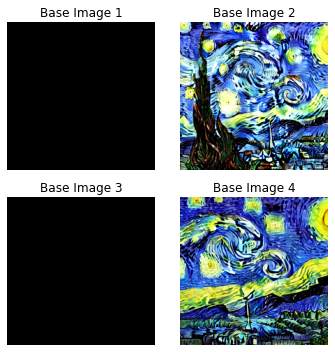

Epoch 4/11: 100%|██████████| 11/11 [00:26<00:00,  2.40s/it, loss=0.000822]


Epoch 4 completed!


Epoch 5/11:  91%|█████████ | 10/11 [00:04<00:00,  2.36it/s, loss=0.0148]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

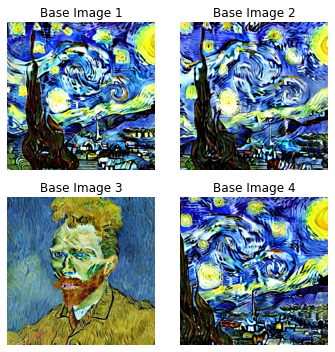

Epoch 5/11: 100%|██████████| 11/11 [00:26<00:00,  2.44s/it, loss=0.0148]


Epoch 5 completed!


Epoch 6/11:  91%|█████████ | 10/11 [00:04<00:00,  2.36it/s, loss=0.0594] 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

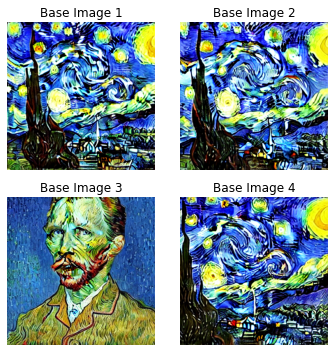

Epoch 6/11: 100%|██████████| 11/11 [00:26<00:00,  2.41s/it, loss=0.0594]


Epoch 6 completed!


Epoch 7/11:  91%|█████████ | 10/11 [00:04<00:00,  2.37it/s, loss=0.119]   

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

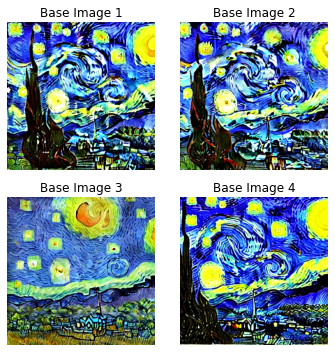

Epoch 7/11: 100%|██████████| 11/11 [00:26<00:00,  2.41s/it, loss=0.119]


Epoch 7 completed!


Epoch 8/11:  91%|█████████ | 10/11 [00:04<00:00,  2.40it/s, loss=0.034] 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

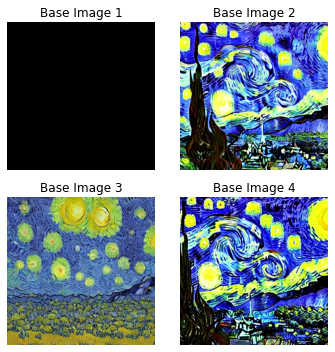

Epoch 8/11: 100%|██████████| 11/11 [00:26<00:00,  2.45s/it, loss=0.034]


Epoch 8 completed!


Epoch 9/11:  91%|█████████ | 10/11 [00:04<00:00,  2.37it/s, loss=0.0543] 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

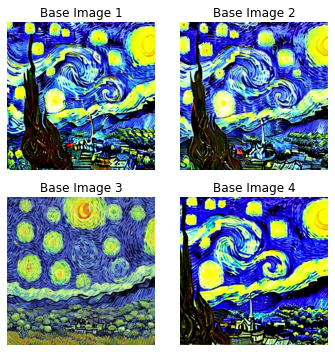

Epoch 9/11: 100%|██████████| 11/11 [00:26<00:00,  2.41s/it, loss=0.0543]


Epoch 9 completed!


Epoch 10/11:  91%|█████████ | 10/11 [00:04<00:00,  2.37it/s, loss=0.0472] 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

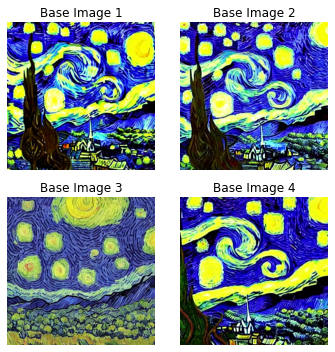

Epoch 10/11: 100%|██████████| 11/11 [00:26<00:00,  2.40s/it, loss=0.0472]


Epoch 10 completed!


Epoch 11/11:  91%|█████████ | 10/11 [00:04<00:00,  2.39it/s, loss=0.00794]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

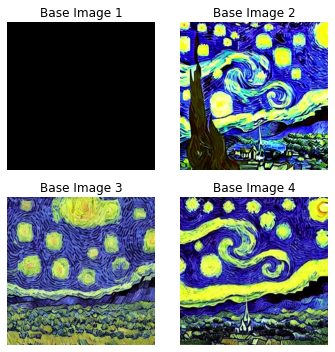

Epoch 11/11:  91%|█████████ | 10/11 [00:26<00:02,  2.70s/it, loss=0.00794]

Epoch 11 completed!


In [19]:
training_wo_imma(
    unet, vae, text_encoder, tokenizer, dataloader, optimizer, lr_scheduler, 
    optimizer_lora, lr_scheduler_lora, accelerator
)

### Training with IMMA

Epoch 1/11:  91%|█████████ | 10/11 [00:03<00:00,  2.46it/s, loss=0.119]  

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

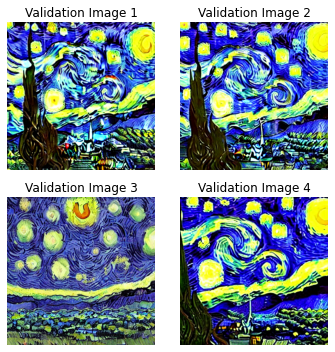

Epoch 1/11: 100%|██████████| 11/11 [00:25<00:00,  2.33s/it, loss=0.119]


Epoch 1 completed!


Epoch 2/11:  91%|█████████ | 10/11 [00:03<00:00,  2.46it/s, loss=0.00688]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

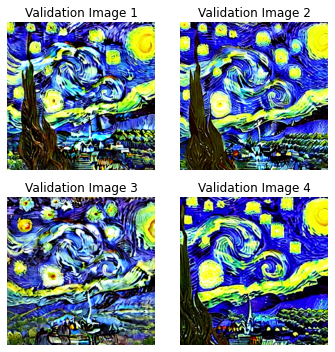

Epoch 2/11: 100%|██████████| 11/11 [00:25<00:00,  2.32s/it, loss=0.00688]


Epoch 2 completed!


Epoch 3/11:  91%|█████████ | 10/11 [00:03<00:00,  2.48it/s, loss=0.0516]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

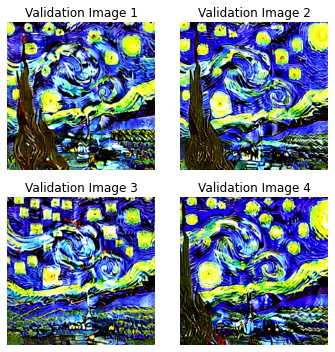

Epoch 3/11: 100%|██████████| 11/11 [00:25<00:00,  2.31s/it, loss=0.0516]


Epoch 3 completed!


Epoch 4/11:  91%|█████████ | 10/11 [00:03<00:00,  2.50it/s, loss=0.0545] 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

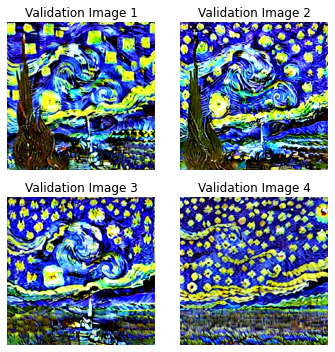

Epoch 4/11: 100%|██████████| 11/11 [00:25<00:00,  2.33s/it, loss=0.0545]


Epoch 4 completed!


Epoch 5/11:  91%|█████████ | 10/11 [00:03<00:00,  2.52it/s, loss=0.225]  

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


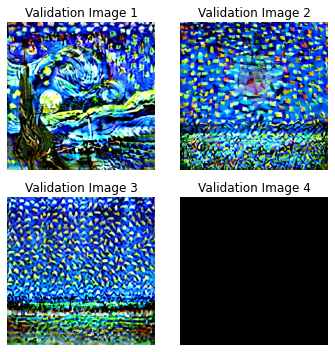

Epoch 5/11: 100%|██████████| 11/11 [00:25<00:00,  2.34s/it, loss=0.225]


Epoch 5 completed!


Epoch 6/11:  91%|█████████ | 10/11 [00:03<00:00,  2.59it/s, loss=0.00372] 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

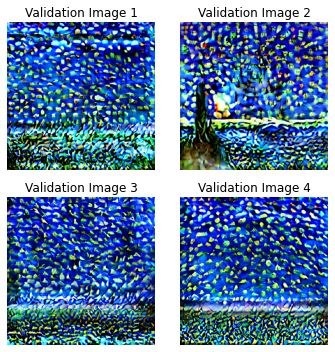

Epoch 6/11: 100%|██████████| 11/11 [00:25<00:00,  2.36s/it, loss=0.00372]


Epoch 6 completed!


Epoch 7/11:  91%|█████████ | 10/11 [00:03<00:00,  2.52it/s, loss=0.00242]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


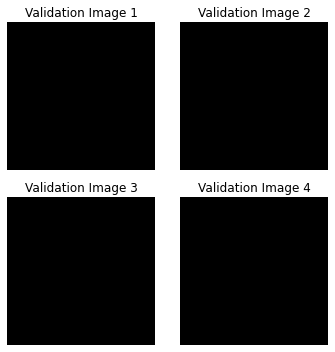

Epoch 7/11: 100%|██████████| 11/11 [00:25<00:00,  2.32s/it, loss=0.00242]


Epoch 7 completed!


Epoch 8/11:  91%|█████████ | 10/11 [00:03<00:00,  2.47it/s, loss=0.000498]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

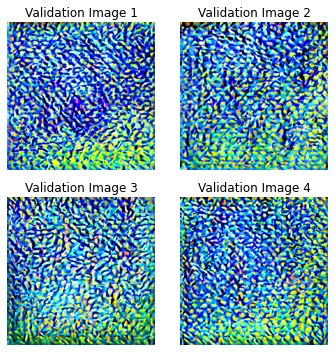

Epoch 8/11: 100%|██████████| 11/11 [00:26<00:00,  2.40s/it, loss=0.000498]


Epoch 8 completed!


Epoch 9/11:  91%|█████████ | 10/11 [00:03<00:00,  2.41it/s, loss=0.0716] 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/30 [00:00<?, ?it/s]

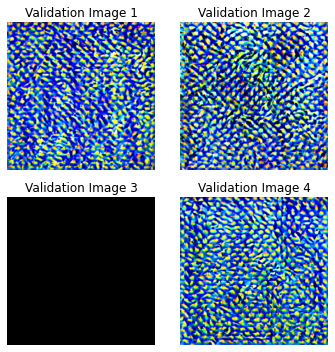

Epoch 9/11: 100%|██████████| 11/11 [00:26<00:00,  2.42s/it, loss=0.0716]


Epoch 9 completed!


Epoch 10/11:  91%|█████████ | 10/11 [00:03<00:00,  2.48it/s, loss=0.0384] 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

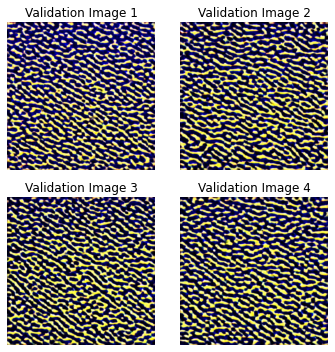

Epoch 10/11: 100%|██████████| 11/11 [00:26<00:00,  2.37s/it, loss=0.0384]


Epoch 10 completed!


Epoch 11/11:  91%|█████████ | 10/11 [00:03<00:00,  2.45it/s, loss=0.389]  

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

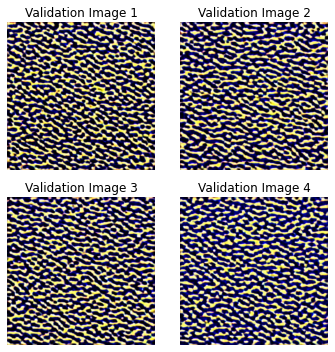

Epoch 11/11:  91%|█████████ | 10/11 [00:26<00:02,  2.62s/it, loss=0.389]

Epoch 11 completed!


In [20]:
training_w_imma(
    unet, vae, text_encoder, tokenizer, dataloader, optimizer, lr_scheduler, 
    optimizer_lora, lr_scheduler_lora, accelerator
)

### Evaluate CLIP, DINO, and lpips Score

In [21]:
class Evaluator(object):
    def __init__(self, device, metric) -> None:
        self.device = device
        self.model, clip_preprocess = clip.load('ViT-B/32', device=self.device)
        self.metric = metric
        if self.metric == "dino":
            self.model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16').to(torch.float32).to(device)
        elif self.metric == "lpips":
            self.model = lpips.LPIPS(net='alex')

        self.clip_preprocess = clip_preprocess
        
        self.preprocess = transforms.Compose([
            transforms.Normalize(mean=[-1.0, -1.0, -1.0], std=[2.0, 2.0, 2.0]),  # Un-normalize
            *clip_preprocess.transforms[:2],  # Unpack Resize and CenterCrop
            transforms.Lambda(lambda x: x.to(torch.float32)),  # Ensure tensor is float32
            *clip_preprocess.transforms[4:],  # Unpack Normalize
        ])

        # Ensure the model runs in float32
        self.model.float()

    @torch.no_grad()
    def encode_images(self, images: torch.Tensor) -> torch.Tensor:
        # Ensure all images are float32
        processed_images = [self.preprocess(img).to(self.device).to(torch.float32) for img in images]
        processed_images = torch.stack(processed_images)  # Stack into a batch
        return self.model.encode_image(processed_images) if not self.metric == "dino" else self.model(processed_images)

    def get_image_features(self, img: torch.Tensor, norm: bool = True) -> torch.Tensor:
        image_features = self.encode_images(img)
        if norm:
            image_features /= image_features.clone().norm(dim=-1, keepdim=True)
        return image_features

    def img_to_img_similarity(self, src_images, generated_images):
        if self.metric == "lpips":
            return 1.0 - torch.mean(self.model(src_images, generated_images))
        src_img_features = self.get_image_features(src_images)
        gen_img_features = self.get_image_features(generated_images)
        similarity = (src_img_features @ gen_img_features.T).mean()
        return similarity

In [22]:
def image_loader(image_name, lpips=False, clip=True):
    image = Image.open(image_name)
    if not image.mode == "RGB":
        image = image.convert("RGB")
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    if lpips:
        image = (image-0.5)*2
    return image.to(torch.float)

def get_files(path, epoch, is_lpips=False):
    file_names = sorted([file for file in path.glob(f"{epoch}_*.png")])
#     print(f"Loading {len(file_names)} files for epoch {epoch}")  # Debug output
    return [image_loader(file, is_lpips) for file in file_names]

def get_reference_files(path):
    file_names = []
    for extension in ["jpg", "png", "jpeg"]:
        file_names.extend(list(path.glob(r'*.{}'.format(extension))))
    return [image_loader(file) for file in file_names]


In [23]:
# Temporarily revert default dtype to float32
default_dtype = torch.get_default_dtype()
torch.set_default_dtype(torch.float32)
clip_model = Evaluator(device=Config.device, metric='clip')
dino_model = Evaluator(device=Config.device, metric='dino')
lpips_model = Evaluator(device=Config.device, metric='lpips')

# After CLIP operations, restore dtype if needed
torch.set_default_dtype(default_dtype)

Using cache found in /home/kim2903/.cache/torch/hub/facebookresearch_dino_main


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/kim2903/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kim2903/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/kim2903/.local/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [24]:
imsize = 64
loader = transforms.Compose([
    transforms.Resize((imsize, imsize), antialias=True),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

path_reference = pathlib.Path(DataConfig.reference_path)
path_imma = pathlib.Path(DataConfig.imma_path)
path_base = pathlib.Path(DataConfig.base_path)

image_names = os.listdir(DataConfig.imma_path)
epoch_ids = sorted(set(name.split("_")[0] for name in image_names if '.png' in name or '.jpg' in name))

files_reference = torch.cat(get_reference_files(path_reference), dim=0)

In [25]:
# clip_model = Evaluator(device=Config.device, metric='clip')
df1 = pd.DataFrame()
clip_baseline = {}
clip_imma = {}
for epoch_id in epoch_ids:
    files_imma = torch.cat(get_files(path_imma, epoch_id), dim=0)
    files_baseline = torch.cat(get_files(path_base, epoch_id), dim=0)
    # Compute two scores: (ref, base), (ref, imma)
    clip_baseline[epoch_id] = clip_model.img_to_img_similarity(files_reference, files_baseline).detach().cpu().numpy() # compute metric for base
    clip_imma[epoch_id] = clip_model.img_to_img_similarity(files_reference, files_imma).detach().cpu().numpy() # compute metric for imma    

df1[f"w/o IMMA"] = pd.Series(clip_baseline)
df1[f"w/ IMMA"] = pd.Series(clip_imma)
os.makedirs("./results", exist_ok=True)
df1.to_csv(f"./results/clip.csv")

/home/kim2903/.local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [26]:
# dino_model = Evaluator(device=Config.device, metric='dino')
df2 = pd.DataFrame()
dino_baseline = {}
dino_imma = {}
for epoch_id in epoch_ids:
    files_imma = torch.cat(get_files(path_imma, epoch_id), dim=0)
    files_baseline = torch.cat(get_files(path_base, epoch_id), dim=0)
    # Compute two scores: (ref, base), (ref, imma)
    dino_baseline[epoch_id] = dino_model.img_to_img_similarity(files_reference, files_baseline).detach().cpu().numpy() # compute metric for base
    dino_imma[epoch_id] = dino_model.img_to_img_similarity(files_reference, files_imma).detach().cpu().numpy() # compute metric for imma    

df2[f"w/o IMMA"] = pd.Series(dino_baseline)
df2[f"w/ IMMA"] = pd.Series(dino_imma)
os.makedirs("./results", exist_ok=True)
df2.to_csv(f"./results/dino.csv")

In [27]:
# lpips_model = Evaluator(device=Config.device, metric='lpips')
df3 = pd.DataFrame()
lpips_baseline = {}
lpips_imma = {}
for epoch_id in epoch_ids:
    files_imma = torch.cat(get_files(path_imma, epoch_id, is_lpips=True), dim=0)
    files_baseline = torch.cat(get_files(path_base, epoch_id, is_lpips=True), dim=0)
    # Compute two scores: (ref, base), (ref, imma)
    lpips_baseline[epoch_id] = dino_model.img_to_img_similarity(files_reference, files_baseline).detach().cpu().numpy() # compute metric for base
    lpips_imma[epoch_id] = dino_model.img_to_img_similarity(files_reference, files_imma).detach().cpu().numpy() # compute metric for imma    

df3[f"w/o IMMA"] = pd.Series(lpips_baseline)
df3[f"w/ IMMA"] = pd.Series(lpips_imma)
os.makedirs("./results", exist_ok=True)
df3.to_csv(f"./results/lpips.csv")

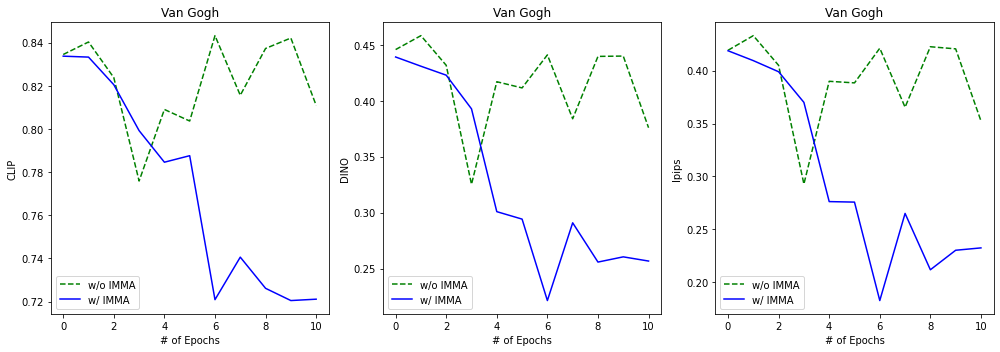

In [28]:
# Load the data from CSV files
clip_data = pd.read_csv('./results/clip.csv')
dino_data = pd.read_csv('./results/dino.csv')
lpips_data = pd.read_csv('./results/lpips.csv')

# Sort by the first column
clip_data[clip_data.columns[0]] = clip_data[clip_data.columns[0]].astype(int)
clip_data = clip_data.sort_values(clip_data.columns[0])
dino_data[dino_data.columns[0]] = dino_data[dino_data.columns[0]].astype(int)
dino_data = dino_data.sort_values(dino_data.columns[0])
lpips_data[lpips_data.columns[0]] = lpips_data[lpips_data.columns[0]].astype(int)
lpips_data = lpips_data.sort_values(lpips_data.columns[0])

# Display the first few rows of each dataframe to understand their structure
clip_data.head(), dino_data.head(), lpips_data.head()


# Data preparation
epochs = clip_data['Unnamed: 0']
clip_wo_imma = clip_data['w/o IMMA']
clip_w_imma = clip_data['w/ IMMA']
dino_wo_imma = dino_data['w/o IMMA']
dino_w_imma = dino_data['w/ IMMA']
lpips_wo_imma = lpips_data['w/o IMMA']
lpips_w_imma = lpips_data['w/ IMMA']

# Creating the plots
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

# Plot for CLIP
axs[0].plot(epochs, clip_wo_imma, label='w/o IMMA', color='green', linestyle='dashed')
axs[0].plot(epochs, clip_w_imma, label='w/ IMMA', color='blue')
axs[0].set_title('Van Gogh')
axs[0].set_xlabel('# of Epochs')
axs[0].set_ylabel('CLIP')
axs[0].legend()

# Plot for DINO
axs[1].plot(epochs, dino_wo_imma, label='w/o IMMA', color='green', linestyle='dashed')
axs[1].plot(epochs, dino_w_imma, label='w/ IMMA', color='blue')
axs[1].set_title('Van Gogh')
axs[1].set_xlabel('# of Epochs')
axs[1].set_ylabel('DINO')
axs[1].legend()

# Plot for lpips
axs[2].plot(epochs, lpips_wo_imma, label='w/o IMMA', color='green', linestyle='dashed')
axs[2].plot(epochs, lpips_w_imma, label='w/ IMMA', color='blue')
axs[2].set_title('Van Gogh')
axs[2].set_xlabel('# of Epochs')
axs[2].set_ylabel('lpips')
axs[2].legend()

plt.tight_layout()
plt.show()